## Call the data of NSMC(Naver Sentiment Movie Corpus)

In [1]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]  # txt파일의 헤더(id label)는 제외
    return data

train_data = read_data('data/nsmcData/ratings_train.txt')
test_data = read_data('data/nsmcData/ratings_test.txt')

In [2]:
# Check the loaded data
print(len(train_data))
print(train_data[0])
print(len(test_data))
print(test_data[0])

150000
['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']
50000
['6270596', '굳 ㅋ', '1']


## Preprocessing of NSMC data

#### Using Okt(Open Korean Text) Class provided by KoNLPy

In [3]:
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'나는 저 하늘을 높이 날고 있어 그때 니가 내게 줬던 두날개로'))

[('나', 'Noun'), ('는', 'Josa'), ('저', 'Noun'), ('하늘', 'Noun'), ('을', 'Josa'), ('높이', 'Noun'), ('날', 'Noun'), ('고', 'Josa'), ('있어', 'Adjective'), ('그때', 'Noun'), ('니', 'Noun'), ('가', 'Josa'), ('내게', 'Verb'), ('줬던', 'Verb'), ('두', 'Determiner'), ('날개', 'Noun'), ('로', 'Josa')]


In [4]:
import os, json
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('data/nsmcData/train_docs.json'):
    with open('data/nsmcData/train_docs.json') as f:
        train_docs = json.load(f)
    with open('data/nsmcData/test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    
    # save as json file
    with open('data/nsmcData/train_docs.json', 'w', encoding='utf-8') as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('data/nsmcData/test_docs.json', 'w', encoding='utf-8') as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        
# Data pretty printer - pprint module
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [5]:
# Check the number of tokens in the analyzed data
tokens = [t for d in  train_docs for t in d[0]]
print(tokens[:10])

['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun', '흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun']


#### Pretreatment vis NLTK

In [6]:
import nltk

text = nltk.Text(tokens, name='NSMC')

print(len(text.tokens))        # Total tokens
print(len(set(text.tokens)))   # Non-Duplicate tokens

pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


#### Graph of 50 most common words using matplotlib

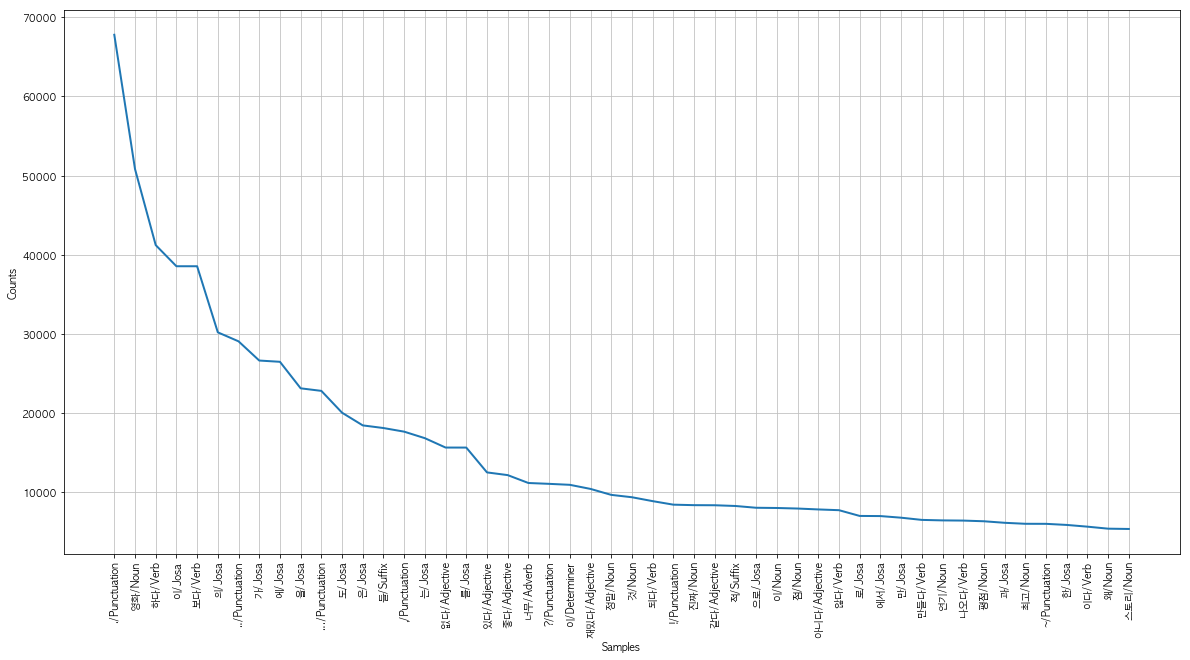

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = '/Library/Fonts/AppleGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20, 10))
text.plot(50)

#### Vectorized using 10,000 commonly used token - Using CountVectorization

In [8]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
train_y = [c for _, c in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
test_y = [c for _, c in test_docs]

# Change data to float
import numpy as np

x_train = np.asarray(train_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')
x_test = np.asarray(test_x).astype('float32')
y_test = np.asarray(test_y).astype('float32')

## Model Definition and Learning

In [9]:
from tensorflow.kerasas import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150000/150000 [==============================] - 25s 168us/sample - loss: 0.3866 - binary_accuracy: 0.8348
Epoch 2/10
150000/150000 [==============================] - 23s 150us/sample - loss: 0.3155 - binary_accuracy: 0.8653 - los
Epoch 3/10
150000/150000 [==============================] - 25s 166us/sample - loss: 0.2891 - binary_accuracy: 0.8800
Epoch 4/10
150000/150000 [==============================] - 20s 133us/sample - loss: 0.2674 - binary_accuracy: 0.8920
Epoch 5/10
150000/150000 [==============================] - 17s 115us/sample - loss: 0.2469 - binary_accuracy: 0.9018
Epoch 6/10
150000/150000 [==============================] - 20s 136us/sample - loss: 0.2268 - binary_accuracy: 0.9112
Epoch 7/10
150000/150000 [==============================] - 18s 120us/sample - loss: 0.2074 - binary_accuracy: 0.9202
Epoch 8/10
150000/150000 [======================

In [10]:
results

[0.4139399326658249, 0.85274]

## Predict results with new data

In [51]:
import pandas as pd

# df = pd.read_csv("data/commentsData/comments_Entertainment.csv", sep=",")
# df = pd.read_csv("data/commentsData/comments_Politics.csv", sep=",")
df = pd.read_csv("data/commentsData/comments_Social.csv", sep=",")

df.shape

(981, 4)

In [52]:
comments = []

comments = df.comments

print(comments[:5])

0    이해찬 이낙연 이인영 조국 유시민 박원순  림종석문재인더불어공산당들  신라젠 바이오...
1                             중앙일보 기자님들은 좋겠다.받아쓰기 잘 해서
2    부산과 인천을 통해서 들어오는 무엇을 가릴려고? 대체 광주와 대구에 뭐하러 남기는데...
3                                            문재인 고향이지.
4    제목하곤.  야. 니들이정말 국민을 중심에 두고있다면검찰결단을 중시한 제목을 뽑아야...
Name: comments, dtype: object


#### Predict whether comment is pos(1) or neg(0)

In [53]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    
    if(score>0.5):
        print("[{}] is positive\n".format(review))
        return 1
    else:
        print("[{}] is negative\n".format(review))
        return 0

#### Calculate the probability of pos or neg

In [54]:
def percentage_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    
    if(score > 0.5):
        print("[{}]는 {:.2f}% chance to be positive\n".format(review, score*100))
        return round(score*100, 2)
    else:
        print("[{}]는 {:.2f}% chance to be negative\n".format(review, (1-score)*100))
        return round(score*100, 2)

In [55]:
predict = []

for index in comments:
    predict.append(predict_pos_neg(index))

[이해찬 이낙연 이인영 조국 유시민 박원순  림종석문재인더불어공산당들  신라젠 바이오주 비트코인 태양광 4차산업 우리들병원 버닝썬  낱낱이 조사해라  청와대 연루된  수십조 주가조작 사기친죄  철저히  밝혀라  !!!!] is negative

[중앙일보 기자님들은 좋겠다.받아쓰기 잘 해서] is positive

[부산과 인천을 통해서 들어오는 무엇을 가릴려고? 대체 광주와 대구에 뭐하러 남기는데? 제2의 수도인 부산을 없애는건 너무 속보인다.] is negative

[문재인 고향이지.] is negative

[제목하곤.  야. 니들이정말 국민을 중심에 두고있다면검찰결단을 중시한 제목을 뽑아야지. 요녀석들 정말.] is positive

[미친 기레기기사] is negative

[우습지도 않다..이걸 기사라고 쓰니?..검찰이 던져주는 뼈다귀만 먹다보니 수준이...] is negative

[졸속처리! 딱입니다요!] is negative

[버닝썬 덮으려고 애쓴다.] is negative

[장난질 참 잘하네 그런 대가리로 나라를 어찌이끌어간담 눈가리고 아옹하십시요표는 더 깎아내리니까 그런데  이나라에서 어찌살으실려고~] is positive

[댓글알바들 니들잠깐돈벌자고 올리는글에 대한민국이 버려졋다] is negative

[더 강력한 검찰(특히 특수부) 만들어라...멍청한 문재인이 자주쓰는 표현...아무도 흔들 수 없는 검찰의 완전한 사법 독립...이게 개혁이다....사실 일반 착한 국민들 특수부 검사 만날 일 평생 없습니다.,,조국같은 특권층 쓰레기들 청소하는 곳이니까요] is positive

[대구를 남기고 부산을 뺀 것은 부산,울산,경남은 이미 장악을 했는데 대구,경북만 아직 장악하지 못했다는 것이 그 첫번째 이유고, 다른 또 하나는 지금 부산시장 오거돈의 모가지가 미투와 선거법위반으로 달랑달랑하거든, 부산시장 오거돈을 파기 시작하면 부시장 유재수, 부산의료원장 노환중이 걸려 나오고 이어서 조국 나오고 해수부 나오고 다 걸려 나오거든. 검찰개

[특수부는 재벌, 정치인,대형경제사건,고의공직자를 수사하는곳이라서 일반인이 저기 갈일이 없다. 근데 폐지하자고 찬성하는 사람들은 뭐냐. 똥인지 된장인지 구분도 못하고 조국이 하니까 그냥 찬성이냐. 무식한건지 무뇌한건지. 촛불들고 재미삼아 돌아다니는 인간들 나라 거들낸다] is negative

[전부 없애지 왜 3개나 남김. 1개만 있어도 다른나라 검찰보다 더 강력함.] is positive

[신라젠ㅋㅋㅋ] is negative

[참 생각없고 대책없는 인간들 많어. 부산 특수부 없애면 부산은 뭐 조사 안하냐? 대구에서 하겠지.동네 경찰서 없애면 그 지역은 무법천지야? 옆동네 경찰서에서 범위 넓혀 치안유지 해주겠지. 슈퍼검찰 힘빼고 균형을 맞추자는건데 뭔 도둑이 어쩌고 저쩌고 참나...] is negative

[끝을본다고  하더만~~ ㅋㅋ파국이  문죄인  뭔가 냄새나네~~] is positive

[국민을 두개 진영으로  갈라놓더니  지역까지  갈등을  부추키냐 ?  쫑개  한마리가  강을 흐린다더니.] is negative

[부산시장 조사 할까봐 그래??먼가 있구만] is negative

[제2의도시 부산은 없애고 제6의도시 광주는 남기네 ㅋ 역시 라도] is positive

[없앤다구? 그럼 다시 만들면 된다.] is positive

[공수처와 수사권 기소권의 구체적 내용안도 국민들이 알아야 한다.  지금까지 그냥 공수처 설치 검경 수사권 기소권 분리라는 구호만 가지고 싸워왔다.  정작 그 내용이 국가 고위공직자 부패와 비리수사, 일반국민들 사건수사에서 어떤 제약을 가져오는 건지 아는 게 없잖아,] is positive

[자기 고향 부산이랑 광주만 쏙 뺐네.] is negative

[똥싸고 튀는데는 일가견이 있네 ㅋ] is negative

[방금 조국장관사퇴 SBS 뉴스 댓글에서 다른사람 공감을 눌렀더니  13명 공감이 8로 바뀌어  이상해서  좀 위쪽의 8명 공감을 누르니  0명으로 변했습니다.  전문가들과  한국당 등은  이문제를 규명해

[역시 범죄자 고향은 부패해야 제맛이지ㅋㅋ] is negative

[제대로다 이래서 검찰이 조리돌림시켰네] is positive

[개혁획실히 해라 이번엔.] is positive

[사람 살인해도 위법사항만 인멸하면 무죄인 나라가 되었다. 위법사항만 감추자~^^] is positive

[좃이나 조꾸기 건빵이다 엿 처먹어라] is positive

[이따가 2시에 좃국 사퇴 기좌회견 한다고 엠바고 카톡으로 돌더라 ㅋㅋㅋㅋㅋ 과연] is negative

[조국 한놈때문에 부산은..지금부터 도둑사기범 조국이 감옥갈때까지...부산부곡이다] is positive

[식구들이 부산에 살고 있으니 부산빼고 싶었겠지 호로 좃국] is positive

[조국이 그러라고 한 거 아닌디~~~? 먼저 제안 올린 사람 찾아서 패~~~] is positive

[제목 장난치지 마라] is negative

[범죄피의자가 무슨 검찰개혁이냐.] is negative

[느그 석열이가 그렇게 하자고 햇대 으이구.. 좀 알아보고 댓글을 달지] is negative

[특수부를 없애겠다는 건 본인들의 비리를 덮겠다는것과 동일한 행동 특수부는 물론 검찰자체가 일반 국민이랑 아무 상관없는데 저들이 저렇게 저기에 매달리는건 너무나도 이유가 뻔하지 않은가? 이미 민주당에는 국민이 없다] is negative

[쒸레기 좆국문재앙정권초 반대세력을 적폐로 몰아 수사할때는 특수부 대거 늘리더니  죄국이 지죄가 들어나 수사당하니 검찰개혁이라는 탈을쓰고 본인과 범죄가족의 죄를 덥고자하는 사법농단을 자행하고있다는걸 몇몇 문슬람광신도를 제외한 대한민국 국민들은 너무도 잘 알고있지.] is negative

[조국 권력 1위가 그이 확실하내 ㅋㅋ  좌파 쫄따구들 찍소리못하고  조국 구두딱고 있내 ㅋㅋ  더불어구두딱~~~으당] is negative

[특수부가 축소되면 일반시민들이 좋아할까 거악 범죄자들이 좋아할까요?  왜 졸속처리를 서두르나요?] is negative

[제발 조국이좀 구속해라 이게 나라냐

[전국 3개 청에만 특수부를 남기는 이번 방안은 앞선 지난 1일 윤석열(59) 검찰총장이 검찰개혁 방안으로 발표한 것이다. 이를 조 장관이 수용한 것이다.] is negative

[검찰 개혁 후 언론개혁까지 빠르게 합시다!!] is positive

[조국스럽구나나라에  망조가 들었다이기야] is positive

[이거 윤석렬이 먼저 3곳만 남기자고 한건데.... 조선은 정말 일부러 조국 엿먹이려고 하는게 너무 티나요] is negative

[대검에서 대구로 정한 걸 수용했는데 또 이상한 프레임 짜고 뭣도 모르고 일단 광광대고 보는 일베충들 ㅋㅋㅋ] is positive

[부산도 특수부 있어야지!!!!] is positive

[조국이 조국하는구나] is positive

[한국 제2의 대도시 부산을 뺀다?? ㅋㅋㅋㅋ 누굴 바보로 아나] is negative

[범죄자가 뻔뻔하게 설치고 다니는 나라...진짜  경험해보지 못한 이상한 나라가 됐다] is negative

[당정청 모두 같은 이해관계에 있는 사람들만 모여 논의를 하니 객관적이고 형있는 결과가 나올리 없겠네요......] is negative

[사법 장악, 공수처 결사반대합니다, 잘몰랐눈데 내용 알고보니 독재기관입니다!] is positive

[왜긴...윤씨가 방안을 내놓은거 조국 장관이 수용한거지~~  제목 뽑는 수준...] is negative

[기사 제목 보면 특수부 남긴게 조국이 한것이라고 하것다.ㅋㅋㅋ검찰이 한걸 왜 조국한테 넘겨ㅋㅋ] is positive

[기레기 제목봐라.. 대검에서 영남지역은 대구로 정했다며..] is negative

[검찰개혁->언론개혁] is negative

[개념도 없고 생각도 없도준비도 없이 ~둥이만 놀라네.아래서 올리면 검토 조차 힘든 판박이고무도장 그대가 꿈꾸는 개혁과 아름다운정의이라.] is negative

[윤석열 안을 수용한건데 제목 꼬라지ㅉㅉ] is negative

[너네끼리 다 헤쳐먹네~이 썩어빠진 문재인정권과 민주당 그리고 조

[특수부 축소하고 공수처에 바지처장 앉혀도 물재인은 못 지킨다 . 초연결 시대다 감추려고 노력해도 비리 , 불법은 탄로난다 . 물재인을 지킬 방법은 수 년째 공석인 청와대 특별감찰관 임명하고 인사검증 . 대통 친인척 , 특수관계인관리 철저히 하는 민정수석 임명하고 정치를 꼼수가 정도로 하고  눈 뜨고 귀 열어 국민과 야당의 고언을 새기고 계파와 진영이 아닌 온 국민을 상대로  정치하면 살길은 있다] is negative

[당연하지. 죄인이랑 젖국이 주소지 퇴임후 고발장 넘치니까] is positive

[댓알바들아 언제적 지역논리 펼치고 자빠졌냐ㅉㅉ 생각이 쉬다 못해 썩어문드러졌네 제발 현생 좀 살아라 아 기사도 좀 제대로 읽고] is negative

[중앙일보 기레기들 화이팅!] is positive

[전라도는 그렇타구 치구 부산 니들은 문제인 민주당 전나찍어지구나서 지금와서 왜들떠드냐 이럴줄 모르구 찍어준거냐 좌빨은 다 똑같지] is negative

[뮈로보나 대한민국의 제2의도시는 부산 아닌가? 종북좌파들이 좋아하는 공정, 형평, 균형 차원에서도 부산이 빠지면 말이 안된다. 적폐를 쌓기위한 검찰개혁인가?  국정을 농단하는 문재앙, 조국 족속들 탄핵이 될 수 밖에 없네...] is negative

[사는 곳이 서울인데 무슨 부산타령인지. 그럼 자유한국당과 김무성이가 좋아하겠다.] is positive

[중앙기레기 제목 투명하네. 니들은 진짜 혐오조장으로 폐간되어야할 핵 폐기물 수준인듯.] is negative

[공산주의로 가는길을 가고있네] is positive

[제목 뽑는 꼬라지. 양아치네. 조회수 높이고 싶어 애를 쓴다.] is negative

[크크크큭. 좌빨수레기들 대단하다] is positive

[거짓으로만 살아온 쓰레기가 무슨 검찰개혁이냐 곧 깜빵에서 평생썩어자빠질놈이 정말 너무 뻔뻔하고 양심없는 쓰레기인간 국민들을 더이상 속이지말고 국민들이 더 이상 분노하게 만들지말고 차라리 자살을해서 국민들께 용서를 빌어라.] is nega

[이시키 부산출마 의식하는거겠지 어림반푼어치도 없다  부산특수부검찰 있으면  또 사기치는데 걸림돌되니 어쩔수가없지] is positive

[개혁은 하야손으로 해야지 어떻게 검은 손으로 개혁을 하나? 이런 개혁은  조국 자신을 위한 가짜개혁이다. 사법시스템을 망가뜨린 시커먼 검은 손들의 개혁? 참 웃긴다. 윤석열 총장의 하얀손으로 검찰개혁을 하길 기대한다.조국 OUT! 답은 조만대장경에 다 있다.] is negative

[없애고 축소하고 검찰개혁 참 쉽죠잉...조국 구속 못시키면  삼성도 수사 종결해라..] is positive

[진짜 이게 누구를 위한 개혁인가?조국자신을 위한 개혁이라면 당장 구속시켜서 이번 법무부장관 인사 논란을 끝장내라.] is positive

[쓰레기임을 자인하네.] is negative

[모가 그리 급했냐? 공휴일에 자기 편만 모며 졸속 회의 후, 또 발표??  정경심 재판이 18일이라 발등에 불 떨어졌냐? 윤총장님 음해 공작  시나리오도 안 먹히니깐 막가파구만. 에라이 퉷. 의자에 앉아 있는 꼬락서니 봐랒.  범죄자가 무슨 낯짝으로 저러냐. 양심도 없고 창피함도 없는 철면피, 인간임??] is negative

[거같은  자가 지랄하고 자빠전데. 너나 개혁해라. 이 xxx야.] is negative

[조국을 구속시키고 사법개혁을 하면 모양새가 좋은데] is positive

[조국  역겹다] is negative

[페어플레이 하세요!!!. 현정부 재판개입 지나칩니다. 죄가 있는 곳에 마땅히 검찰의 수사가 필요합니다!! 죄짓지 않고 살았다면 검찰개혁을 왜 부르짓나요? 일반 국민에게는 그 보다 더 중요한 것은 비리가 있는 곳에 정의로운 검찰의 수사가 있는 것입니다. 수사나 철저히 받으세요!!] is positive

[전라도  지들이  나라 망치고 다 해쳐먹고 있음  보고도 모르냐 ?  그러고도  왜 지역감정 부추끼냐고 ?  95 % 민주당 몰표가 전라임   그런말 나오냐] is positive

[어차피낸총선지나면문재앙이랑조

[서울대전 부산해라] is positive

[김기춘, 황교안, 양승태, 우병우, 김학의, 나경원 같은 인간들도 다시 전면 재조사해야한다. 그래야 공평하다. 조국처럼 사돈에 오촌까지 다 털어보자~ 뭐가 나올지 궁금하다.] is positive

[쓰  레기들만  모이는구만] is negative

[웃기는 세상이되는구나  훗날 후회할거다] is positive

[반일한다면서 이건또 일본따라가냐?ㅋㅋㅋ] is positive

[사는게 졸속인생인 조사기네인데.ㅋ뭘기대하냐ㅋ  교도소를 확장해라. 느그들 전부 구속해야.ㅋ] is negative

[국민은 허수아비!국민을 위해 법가정치  권력지배자들 을 청소,.ㅡㅡㅡ법조인 정치참여  금지법 ㅡㅡㅡㅡ만들어야!공수처 신설시  법조인 참ㅇ여 금지법.이게 진정한 개혁이다.개,돼지 국민성 !정치에 선동되는 진보,보수?] is negative

[부산털면 좆국이 문가 모두 무사하지 못하니 부산 특수부 없애는거지.. 미친 ㅅㅂ 좆국 감빵 빨리보내라!!] is negative

[경남 양산에 지들이 뿌려 논 똥이 많나보지. 이렇게 지들 이익에 맞게 협의없이 법을 만들고 없애고 하는게 독재지 뭐가 독재 임? 게다가 다수의 죄를 지은 범죄자가 그걸 수사하는 검찰 위에서 조종하고 인사권 감찰권까지 행사. 참 나랏꼴이 2년만에 골로 감] is negative

[답답허다~~] is negative

[그래 특수부는 서울,대구,광주만 남기고 조국 니네 집안도 싹다 구속시키고 너만 남쟈~~~~] is negative

[현재 장관들 싹다 사형좀] is positive

[사시노패스의 졸속 검찰개혁 명분도 정당성도 없다] is negative

[박태인기자님 [OOO]들은 사진으로 올리지말아주세요 정 올려야 할때는 모자이크 부탁드립니다 최소한 눈이라도 검은줄로 그어주세요 기사읽기가 정말 구역질 나고 역겨워 고통스럽습니다] is negative

[특수부 줄이는 게 머가 그래 큰 개혁이라고 조국 아니면 안된다 우기냐?] is negative


[내란 반역 간첩 선전선동 이런거 다루는 곳은 어디 있겠지] is negative

[정권끝나면 다 원복이니까 아무 의미 없다 , 확실한건 족국과 문재앙은 깜빵에 있다는 거다] is negative

[법조계 반발 좋아하시네 국민이 원한다 ㅅㄲ들아] is negative

[넌 꺼져라.면상 보기도 싫다.개혁은 개뿔] is negative

[나중에는 똥싸는것도 논란이라 하겠네] is negative

[조국부터 개혁대상이다  범죄자가  무엇을 하냐   죽은 소대가리가 웃는다 조적국 기생충 사기군 가족  추잡한새끼] is negative

[급하게하면할수록 탈이 크게나지..] is negative

[살다 살다 저런 놈은 첨본다] is positive

[ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ별것이 다 논란이냐 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ] is negative

[범죄자가 무슨 개혁을 한다고 지나가는 개가 웃는다..국민들이 어디 바보줄아나?이노무 정권은 전부 돌아이들뿐이네..너거집 개혁부터하는게 맞지싶은데요..기본 양심이라곤 찾아볼수가 없네..양심.기본,근본?도덕적으로 아웃이다] is negative

[이넘 얼굴봐라 요즘잘쳐먹고있네 피부좋은거봐  사기쳐서 돈많이챙기니좋냐] is negative

[국민도 납득하기 힘듦!!!!!] is negative

[또 급한척  졸속처리냐... 법조계의 논의는 필요없고? 이게  소통이 잘되는 정부라고 생각하나? 모든게 조국구하기로 밖에 안보인다.. 국민은 불결한 "개혁" 거부한다] is positive

[사노맹 빨갱이 끼] is negative

[입만 열면 거짓말인 양치기 아저씨가 개혁? 카메라앞에서 거만 다리쩍벌남.. 뭐가 그리 당당하지? 문통빽 아님 벌써 핸폰압수에 계좌추적에 증거잡혀 빵갔을 가족사기단이..집수사 영장도 기각되 이미 증거인멸 다한후, 한달후나 집안수색하고..일반인이었음 그리 특혜받았겠나?요즘은 거짓이 진실인양 온통 윤리와 법칙이 무너진 사회.] is negative

[진심 개한심하다ㅋ ㅋㅋ 아무도 인정하지않는

In [56]:
percentage = []

for index in comments:
    percentage.append(percentage_pos_neg(index))

[이해찬 이낙연 이인영 조국 유시민 박원순  림종석문재인더불어공산당들  신라젠 바이오주 비트코인 태양광 4차산업 우리들병원 버닝썬  낱낱이 조사해라  청와대 연루된  수십조 주가조작 사기친죄  철저히  밝혀라  !!!!]는 58.44% chance to be negative

[중앙일보 기자님들은 좋겠다.받아쓰기 잘 해서]는 90.84% chance to be positive

[부산과 인천을 통해서 들어오는 무엇을 가릴려고? 대체 광주와 대구에 뭐하러 남기는데? 제2의 수도인 부산을 없애는건 너무 속보인다.]는 84.14% chance to be negative

[문재인 고향이지.]는 82.19% chance to be negative

[제목하곤.  야. 니들이정말 국민을 중심에 두고있다면검찰결단을 중시한 제목을 뽑아야지. 요녀석들 정말.]는 82.03% chance to be positive

[미친 기레기기사]는 86.17% chance to be negative

[우습지도 않다..이걸 기사라고 쓰니?..검찰이 던져주는 뼈다귀만 먹다보니 수준이...]는 89.13% chance to be negative

[졸속처리! 딱입니다요!]는 50.24% chance to be negative

[버닝썬 덮으려고 애쓴다.]는 96.65% chance to be negative

[장난질 참 잘하네 그런 대가리로 나라를 어찌이끌어간담 눈가리고 아옹하십시요표는 더 깎아내리니까 그런데  이나라에서 어찌살으실려고~]는 83.06% chance to be positive

[댓글알바들 니들잠깐돈벌자고 올리는글에 대한민국이 버려졋다]는 97.73% chance to be negative

[더 강력한 검찰(특히 특수부) 만들어라...멍청한 문재인이 자주쓰는 표현...아무도 흔들 수 없는 검찰의 완전한 사법 독립...이게 개혁이다....사실 일반 착한 국민들 특수부 검사 만날 일 평생 없습니다.,,조국같은 특권층 쓰레기들 청소하는 곳이니까요]는 100.00% chance

[ㅎㅎ ㅎ...동네 웃낀다. 자한당이 나라쳐말아드시고 더불당이 여당이 됐는데대통령은 양산, 조국 부산인데 갱상도는전라도를 절나 욕해요. 웃기지 않나요?하여튼 양아치이색히들일세~~]는 82.36% chance to be negative

[적폐중의 적폐~ 이미 불은 지펴졌다]는 74.69% chance to be negative

[쩔라도 역시 ㆍㆍ현 정부가  잘해준다 문통 팍팍 밀어라  부산에 없는것 이상하네]는 84.64% chance to be negative

[서울 대구, 광주, 대전 찍고 터닝~ 검찰개혁 어디 있나, 법무부 있나, 청와대 있나, 광장에 있나~~]는 73.72% chance to be positive

[1달새 얼굴이 쪽 빠졌네. 그려~]는 59.35% chance to be negative

[말만 하면뭐함ㅋㅋ 고생하는건밑어직원들인덕 높은데일수록 가만히앉아서 어떡해바꿀까 대가리만굴리지말고 몸으로실천해라좀 일도안한 국회으원 연봉은 절.라게많이받아가면서 온갖 갑질은ㅋㅋㅋ머대단한지아는갑네]는 99.70% chance to be negative

[문정권 들어서고 좌빠리들이공공연히 떠드는개소리가  수구꼴통 대구를 없애야한다고 하더만.,..너거 대가리 먼저 뿌셔지겠다! 대갈통간수 잘~~~해라!좌빨들아.]는 94.19% chance to be positive

[긴 싸움이엿다. 잘 가라 조국아. 니덕에 문정권 끝낼날이 얼마남지 않았다.]는 94.57% chance to be negative

[부산은 5억원이 있어서 일부러 뺐습니다...]는 74.78% chance to be negative

[이건 뭐 맨날  만들고 없애고 하면 개혁인가?]는 91.16% chance to be negative

[지랄을한다.그게개혁이냐.이지랄할라고.어이구.개혁한번.거창하네.서민들이.억울한거.없애는.개혁이아이고.너거끼리해처묵는.개혁이냐.국민들을위한.개혁은없네.너거끼리.다해처무라.썩어빠진나라.대한민국.만세.]는 80.78% chance to be negative


[그만해 사퇴한다고하잖아 드럽게 괴롭히네]는 98.11% chance to be negative

[정의가 이긴다 불변의 법칙 조국ㅅㄲ 이렇게 그만둘걸 진작 내려오지  ㅆㄹㄱ]는 99.96% chance to be negative

[광주 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ]는 90.92% chance to be negative

[부산이 핵심이던데 빠졌네]는 66.81% chance to be negative

[분명 무슨 조작질있을듯]는 98.09% chance to be negative

[대한민국  만세 만세 만세!!!!!]는 99.12% chance to be positive

[사퇴 전 딜한거네.]는 60.40% chance to be negative

[아............이렇게 가시면 안됩니다 ....ㅎ ㅏ..... 조금만 견디시지..]는 51.78% chance to be positive

[국가전복 세력을 국민의 뜻으로 왜 끌어내리지 못 하는가~~??? 그냥 국민투표 하자~~!!! 국민이 뽑은 대통령~ 국민이 탄핵시키자~~!!! 국회는 헛짓거리 하지말고 국민투표 날이나 잡아라~~~!!! 촛불이 국민의 민심이라 생각한다면 좌빨들도 국민투표에 응해라~~!!!]는 99.92% chance to be negative

[조국이 반대하는 넘들은 다 사기꾼들이 대부분이드라.]는 78.11% chance to be negative

[제목 뽑은 꼬라지 으으으으 드러워]는 99.81% chance to be negative

[결국 자리 나눠먹기네 젠장]는 99.25% chance to be negative

[사퇴하고 가족과 함께 깜빵갑시다.]는 81.08% chance to be positive

[오늘  알았네요중앙일보 사장이 홍석현 아들 이라고..홍석현은 손석희랑 음모 꾸며 박근혜 대통령 탄핵시키고 빨ㄱㅐㅇ이 뽑아 나라 어지럽게 한자들이라 하더군요이젠 중앙일보 구독!!안합니다.!]는 68.27% chance to be negative

[조국 패밀리의 혐의 사건

[하여튼 피의자가 뭔지도 모르는 것들이  시비는  조국 만큼  깨끗한 사람이 어디에 있냐. 지금 까지 수사가  포창장 위조란다. 만약 하버드대 위조 했으면 말을 안겠다. ㅋㅋ]는 99.87% chance to be positive

[부산아닌데웅동이면창원인데]는 65.20% chance to be positive

[우~~~와 ㆍ  조국  다리 벌린거 좀봐~~~가랭이 찢어지겠네 ~~거시기당 이라    거시기 자랑 하려고?]는 86.23% chance to be negative

[부산 시민은 개호구라 조국이 총선에 나와 당선도 되고 대통령이 될 마중물이라 생각하나봐.]는 72.85% chance to be negative

[오냐   니 ㅈ대로 함 해봐라..반드시 니놈은 쇠고랑 찰거다.]는 51.69% chance to be positive

[태극기 들고 시위하는것도 이제 못할수도있다. 국가의 주인이 국민이 아닌 저들것이 될 수도있단말이다. 지금 하는짓으로 봐선 충분히 그럴꺼 같다는 생각이 든다.내년 총선 정신바싹차리고 해야한다. 정말 심각할정도다.]는 96.56% chance to be positive

[검찰보다 언론이 더문제인듯.국민을 바보로만드는 제조기같으네.]는 86.08% chance to be negative

[윤석렬이가 부산빼고 대구 하자고 했네]는 87.32% chance to be negative

[10수가 한다는거 수용이란다 문맹들아 ㅎ]는 96.23% chance to be positive

[부산 포함하면 또 포함한다고 징징거릴꺼면서]는 54.30% chance to be positive

[전국 3개 청에만 특수부를 남기는 이번 방안은 앞선 지난 1일 윤석열(59) 검찰총장이 검찰개혁 방안으로 발표한 것이다. 이를 조 장관이 수용한 것이다.]는 99.77% chance to be negative

[적정한토의와협의가없었다고~ 개혁당사자들이 응하지않았을뿐  토의와협의는2년이  넘었다.]는 80.80% chance to be posi

[깜빵가야할 놈이 검찰을 개혁하려는 더러운 적폐세상]는 93.91% chance to be negative

[그럼 충청은 왜 빠졌냐?.. 딱 보니 서울과 영남 호남에 두었네... 우리나라 분열의 주범은 신문기자의 승진욕심때문이다 라고 주장하면 억지냐?]는 64.95% chance to be positive

[꼼수 그만부리고~~~!!  조국 감방 보내자~~!!!]는 82.17% chance to be negative

[서울만 남겨라]는 85.26% chance to be negative

[완전 조국이 댜통령이고 하느님이네이게 나라냐 욕나온다 내가 문재인찍은게 한이다]는 61.92% chance to be positive

[내가왜 이런 거짓된 자 범죄자들아래서 살아야하지?]는 98.56% chance to be negative

[이딴게 검찰개혁이냐??특수부가 서민과 뭔 상관이야높으신분들 범법행위 느슨하게 해줄려는게 검찰개혁? 이런 명분으로 와해시키는건가?]는 100.00% chance to be negative

[남기면 남기는대로 발광을 했을것들이 대검에서 대구 남기자고 한거 받아준건데 왜 난리냐 이게 트윗이지 기사냐?]는 90.85% chance to be negative

[남기면 남긴다고 지랄 안남기면 안남긴다고 지랄]는 90.69% chance to be negative

[검찰에 발도 안담궈본게 검찰을 개혁한다고? 지나가는 어린이집원생이 웃겠다]는 58.93% chance to be positive

[다리 오무리라 씹땡아]는 56.72% chance to be positive

[서울 외엔 대구-광주... ㅋ 영원한 지역구도로구만. 부산이더니 대구로 바꾼 건 광주랑 균형 맞추기인가?]는 99.94% chance to be negative

[왜 이런자 범죄자 아래서 살아야하지?]는 83.65% chance to be negative

[다음 뉴스 달창이 아지트화 두루킹 사기와 뭐가 다른지? 완전 다른세상 정신병원 사이트인줄 알았다...네이버

[그러게 왜 광주는 놔두고 부산은 없앴냐? 서울 대전 부산 이렇게 하자]는 98.94% chance to be negative

[정적들 팰 땐 열심히 써대다가 지들한테 칼 들이미니 바로 없앰ㅋㅋ]는 96.05% chance to be positive

[겁나 뻔뻔하게 나와서 입터는거보라. 웃겠다]는 96.36% chance to be negative

[너무 하는것 아이야..대놓고 국민을 바보로 하루빨리 문재인 탄핵이 답이다..]는 98.49% chance to be negative

[부산이 대한민국 제2의도시고 인구도 광역시중에 제일많은데 부산특수부폐지?ㅋㅋㅋㅋㅋㅋㅋ좃국새끼 짱돌굴리고 뺑끼존나쓰는데 안그래도된다 범죄자새끼야]는 67.99% chance to be negative

[아직도 중앙일보 보는 사람들이 있네요.]는 57.72% chance to be positive

[진짜 나라가 거꾸로 돌아가는 어메이징 헬조선]는 53.93% chance to be positive

[조국이는 필요없었네? 도장을 잘 찍나?]는 83.91% chance to be positive

[피의자가 검찰개혁... 한다고 웃기는 세상...  도둑이 경찰개혁하고  성범죄자가 여가부 개혁하는 꼴~~앞으로 이완용 같은 인간이 대통령하겠다고 하것네~~]는 71.25% chance to be negative

[영남 지역에 부산지검이 아닌 대구지검에 특수부를 남기는 방안을 먼저 제안한 것은 법무부가 아닌 대검이었다고 한다.  기사나 읽고 댓글달자 ㅉㅉ]는 99.34% chance to be negative

[권한이겠지]는 95.53% chance to be negative

[ㅋㅋㅋㅋㅋ 검찰 개혁은 무슨 ㅋㅋㅋ 결국 검찰도 친문이랑 자기 세력으로 채우기 ㅋㅋㅋㅋㅋ 인맥 정치의 끝 ㅋㅋㅋㅋㅋ]는 92.31% chance to be negative

[부산이 비리의 온상지 인데 왜 특수부를 폐지~~  ??   ㅋㅋㅋㅋㅋㅋㅋㅋ      부산에  암안리에 벌려놓은 비밀사업이  많이 있

[이시키 부산출마 의식하는거겠지 어림반푼어치도 없다  부산특수부검찰 있으면  또 사기치는데 걸림돌되니 어쩔수가없지]는 53.15% chance to be positive

[개혁은 하야손으로 해야지 어떻게 검은 손으로 개혁을 하나? 이런 개혁은  조국 자신을 위한 가짜개혁이다. 사법시스템을 망가뜨린 시커먼 검은 손들의 개혁? 참 웃긴다. 윤석열 총장의 하얀손으로 검찰개혁을 하길 기대한다.조국 OUT! 답은 조만대장경에 다 있다.]는 99.97% chance to be negative

[없애고 축소하고 검찰개혁 참 쉽죠잉...조국 구속 못시키면  삼성도 수사 종결해라..]는 99.85% chance to be positive

[진짜 이게 누구를 위한 개혁인가?조국자신을 위한 개혁이라면 당장 구속시켜서 이번 법무부장관 인사 논란을 끝장내라.]는 74.72% chance to be positive

[쓰레기임을 자인하네.]는 93.35% chance to be negative

[모가 그리 급했냐? 공휴일에 자기 편만 모며 졸속 회의 후, 또 발표??  정경심 재판이 18일이라 발등에 불 떨어졌냐? 윤총장님 음해 공작  시나리오도 안 먹히니깐 막가파구만. 에라이 퉷. 의자에 앉아 있는 꼬락서니 봐랒.  범죄자가 무슨 낯짝으로 저러냐. 양심도 없고 창피함도 없는 철면피, 인간임??]는 99.97% chance to be negative

[거같은  자가 지랄하고 자빠전데. 너나 개혁해라. 이 xxx야.]는 74.60% chance to be negative

[조국을 구속시키고 사법개혁을 하면 모양새가 좋은데]는 99.06% chance to be positive

[조국  역겹다]는 89.48% chance to be negative

[페어플레이 하세요!!!. 현정부 재판개입 지나칩니다. 죄가 있는 곳에 마땅히 검찰의 수사가 필요합니다!! 죄짓지 않고 살았다면 검찰개혁을 왜 부르짓나요? 일반 국민에게는 그 보다 더 중요한 것은 비리가 있는 곳에 정의로운 검찰의

[이건 뭐 장관이라고 지가 하는건 없고 윤총장이 말한거 그대로 하네..뭐하러 그자리 앉아있냐? 집구석 사수하고 공수처 만들려고 가짜검찰개혁 운운하고 있네..]는 99.24% chance to be negative

[검찰개악이다! 특수부 없애기 전에 조국 구속! 그리고 문정권의 개 노릇하는 경찰개혁이 먼저이다!]는 97.61% chance to be positive

[조국이 지맘대로 주무르는데 아 진짜 개열받네 저새끼 진짜 ... 조국은 나가 뒤지길]는 97.92% chance to be positive

[진짜 이건 뭐 자기 맘대로다 어린아이 장난감갖고 노는것처럼ㅎㅎ]는 98.83% chance to be positive

[국민의 명령이다. 범죄자 조국 그 아가리 닫으라]는 81.33% chance to be positive

[부산 넣으면 그대들이 조용히 있지않지. 안넣어도 난리냐?트집잡으려 별거 다 시비건다]는 97.51% chance to be positive

[이젠 대놓고 지꺼만 챙기네 ㅋㅋㅋㅋ 에라이~~ 저런게 법무부장관이라고 ㅉㅉ 하긴 문재앙이도 대통령질 하고 있으니..정말 경험하지 못한 나라를 쳐 만드는중이네]는 99.77% chance to be negative

[일본이 특수부 3개라서 우리도 3개만 남긴다고??? 너희야말로 토착왜구구나!!! 부산에 오거돈 비리 심하게 많지.. 크루즈 사업에 와이파이에... 게다가 조국 동생 조권이 경찰 임명도 좌지 우지 했다하고.. 부산이야말로 가까이 검찰 필요하다!]는 99.96% chance to be positive

[갑자기  소화가 안됨  채널돌림 ㅋ~  설득력  신임도  제로~~~]는 99.93% chance to be negative

[이 작자   꼴 사납다. 집구석도 똑바로 못하는 주재에 국가권력 개혁이라 얼토 당토 않은 짓거리다.]는 99.82% chance to be negative

[ㅋㅋㅋ 도둑옴이 무슨짓 하는거야 ???]는 94.58% chance to be negative



[개혁이라고 내 놓은게 모두 정경심이에게 유리하네 돈있고 권력있으면 죄지어도 괜찮다는건가 그자리에서 물러나 평등하게 수사받고       무죄가 나오면 국민이 당신을 그자리에 다시 앉혀줄건데 뭣이  그리겁나  못내려오는가  그런 처신이 정의아니겠는가  그럼 국민이 더 박수칠거고 정권지지율도 올라갈건데 왜 단순한 노리를 거스르닌지 알수없네 죄를 많이지었는갑네  겁은잔득머고 그정도 배짱으로  나쁜짓은 어찌했노 우리 쪽팔리게 살지는 말자 위선자 조국]는 100.00% chance to be positive

[이걸 조국 욕하는건 좀 아니지.. 대검이 대구남기자고 했다잖아. 대검이 뭔 자신감이 있어서 그런건지는 모르겠지만.]는 66.66% chance to be positive

[조국 아니면 못한다던 개혁이 이런 날탱이식이었나 이런건 조국 아니더라도 누구나 가능 하다]는 99.64% chance to be positive

[가장  부패한자가  반부패수사부를 만든다???개나 소도 웃을 한편의 코메디ㅣ네  충분한 여론수렴도  없이  그리고 법조계원로등   사회 각계각층의  의견  취합도 없이   발등에 떨어진 불처럼그리도 서두르나   아마  조국패밀리  수사가막바지에  다다른 모양이지  그리고 또 폐북에내가  검찰개혁을  완성  시켰노라고   ×랄 떨겠지]는 94.02% chance to be positive

[검찰은 그입 다물라. 지금 반발할 때인가? 김학의 같은 인간들  같으니라고...]는 89.54% chance to be positive

[인구순아닌가 ~~개혁이란  뜻이  먼데  니들바람맞이냐  웃기는것들이네  ~]는 90.07% chance to be negative

[법무부부터 개혁해라  권력이 너무   거악스럽다]는 52.47% chance to be negative

[정말로 한심해요......청와대, 정부, 민주당은.....오직 조국만을 위해서 있는것 같아요.....왜 이렇게 급하게 처리하는지...도대체 알수가 없다......정말 한심하다...검찰

[지금은 세상 모든게 네것인것 같을것이다ㆍ할수있는거 다해바라  더러운 애송이야ㆍ훗날 넌 국가와 전국민을 능멸한죄 사형이다]는 100.00% chance to be positive

[문재인이 무력화시킨 정부조직중 유일하게 살아남아 기능하는 검찰조직이 무너지면,낮은단계의 연방제로 가는 패스트트랙을 타게 됩니다.진짜 죽창들고 저항해야하는 날이 오게됩니다.]는 81.75% chance to be positive

[졸속처리하는 검찰개혁 반대한다]는 88.76% chance to be negative

[조국 진짜 교수 맞긴한가.. 아무것도 모르고 그냥 대충 하는거 같다 보여주기식인가]는 75.68% chance to be negative

[맘대로 하게 봐두고, 나중에 제대로 된 정권이 들어서면 그 때 바로잡으면 됨. 잘못된 결정이나 제도에서 배울기회가 생기는 것!]는 93.39% chance to be positive

[강도가 범죄예방책 발표하는것같네. 범죄자를 법무부수장앉힌 삶은소대가리도, 그자리에 앉아서 범죄자들인 자기가족보호법 만드느라 개소리하고있는 좃국도, 앉아서는 절대 안되는 자리에 앉아서 말도안되는짓거리를 하고있다. 특검으로 철저히 조사하고 처벌해야한다.]는 99.88% chance to be negative

[조시오패스 이 놈은 법무부 들어와서  한다는게 지가 범법저질러 놓은것 감추고, 덥고 ,없에기에 급급하구나 ! 민정수석 할때 나뿐짓은 다하고 !   참나  이런 엽기 드라마 같이 돌아가는 현실을  보니 국민으로서 통탄할 노릇이다  !]는 99.41% chance to be negative

[부산출신 범죄자가 제일 많은데. , 좆국씨 왜이래]는 98.64% chance to be negative

[이양반들.아직 죄가 있는지 없는지도 모르는데 너무 앞서가시네.]는 94.12% chance to be negative

[고담 대구?]는 56.45% chance to be positive

[조국이 지금 발악하는 이유는 이 나라를 공산주의로 만들려

#### Add column to csv file (predict / percent / truelike / wholelike)

In [57]:
df['predict'] = predict
df['percent'] = percentage

truelike = df['like'] - df['dislike']
wholelike = df['like'] + df['dislike']
# truelike.head()
# wholelike.head()

df['truelike'] = truelike
df['wholelike'] = wholelike

df.to_csv('data/commentsData/comments_Social_edit.csv', mode='a', encoding='utf-8')